In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
#import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras import regularizers as rl
from keras.wrappers.scikit_learn import KerasRegressor

from pprint import pprint

In [2]:
pd.set_option('display.max_columns',None)

df = pd.read_csv("kc_final.csv")

In [3]:
df

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [4]:
def age(row):
    if row['yr_renovated'] == 0:
        return int(row['date'][:4])-row['yr_built']
    else:
        return int(row['date'][:4])-row['yr_renovated']  
    
def date_to_day(row):
    row['date'] = pd.to_datetime(row['date'], errors='coerce')
    if str(row['date'])[:4] == '2014':
        return row['date'].dayofyear
    else:
        return row['date'].dayofyear + 365
    
def distance(row):
    max_lat = df.loc[df['price'].idxmax()]['lat']
    max_long = df.loc[df['price'].idxmax()]['long']
    
    return np.linalg.norm(np.array([row['lat'],row['long']]) - np.array(max_lat,max_long))
    

In [5]:
df['age'] = df.apply(lambda row: age(row), axis = 1)

In [6]:
df['day_of_years'] = df.apply(lambda row: date_to_day(row), axis = 1)

In [7]:
def plot_per_variable(variable):
    group = df.groupby([variable])['price'].mean()
    group.plot()
    plt.show()

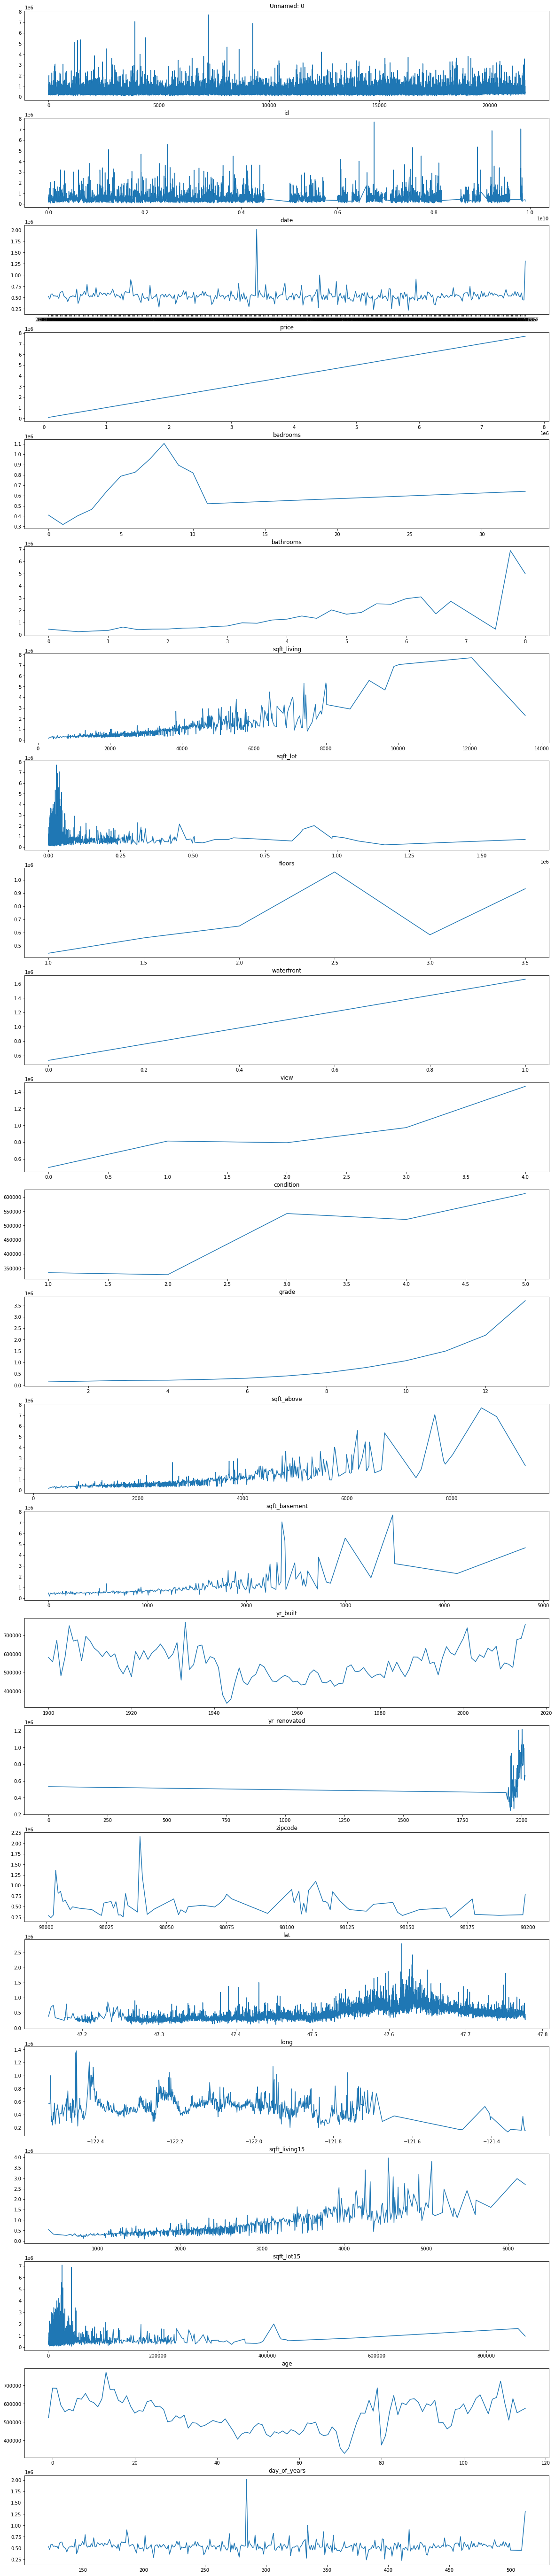

In [8]:
cols = df.columns

groups = [[] for i in range(len(cols))]
for i in range(len(cols)):
    groups[i] = df.groupby([cols[i]])['price'].mean()
    

fig,ax = plt.subplots(nrows = len(cols),figsize = (20,100))

for i in range(len(cols)):
    ax[i].plot(groups[i])
    ax[i].set_title(cols[i])

plt.show()    

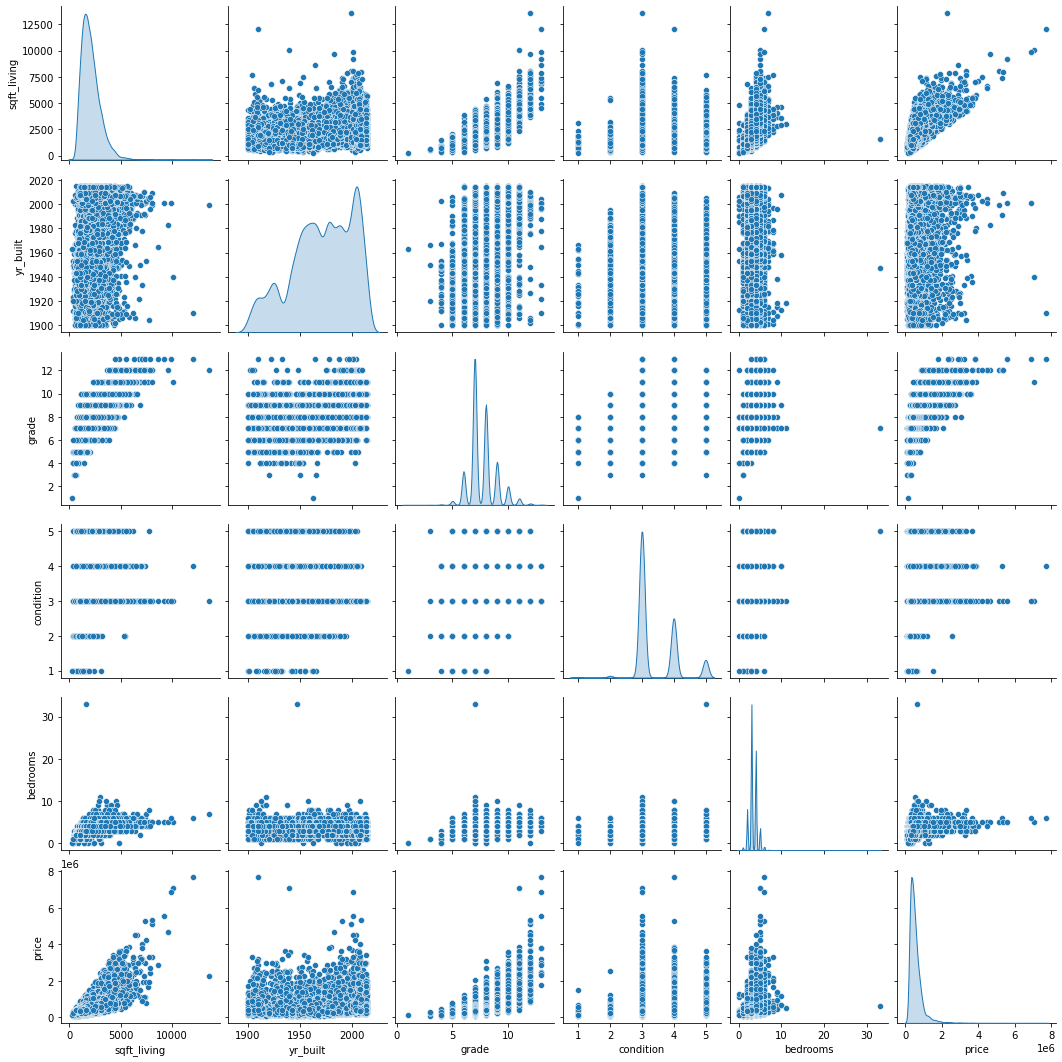

In [23]:
sb.pairplot(df[['sqft_living','yr_built','grade','condition','bedrooms','price']], diag_kind='kde')

plt.show()

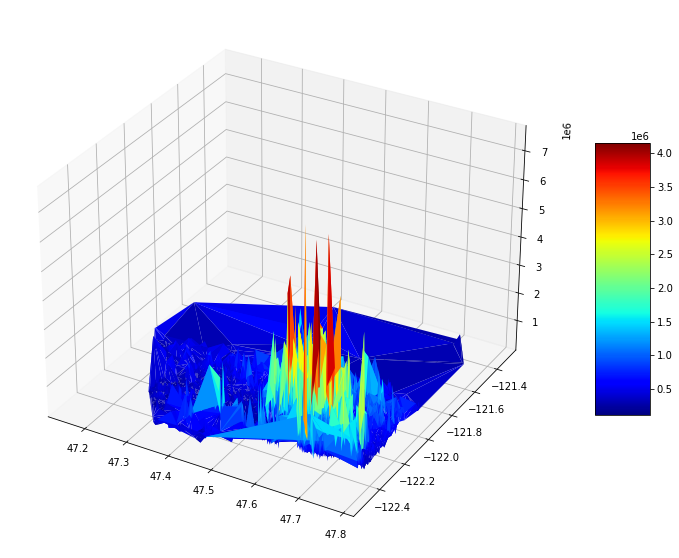

In [9]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(projection='3d')

surf = ax.plot_trisurf(df['lat'], df['long'], df['price'], cmap=cm.jet, linewidth=0.1)
ax.axvline(47.6298,0,0)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [10]:
df['distance'] = df.apply(lambda row: distance(row), axis = 1)

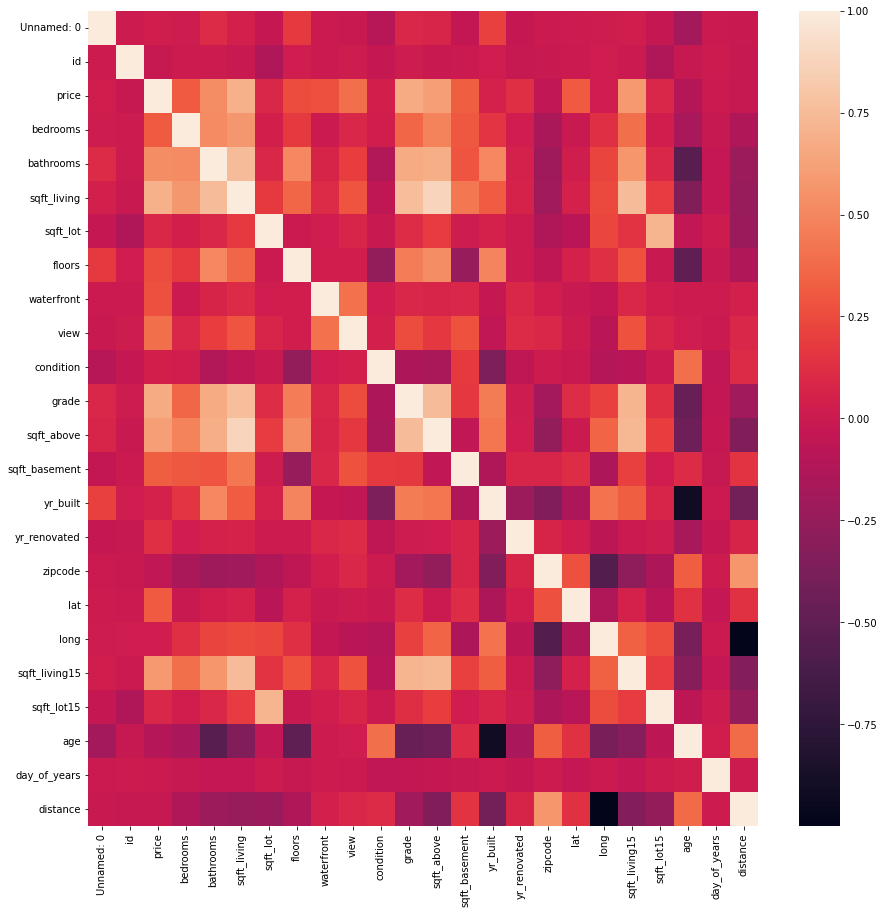

In [11]:
plt.figure(figsize=(15,15))
sb.heatmap(df.corr())

plt.show()

In [12]:
df

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age,day_of_years,distance
0,0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,59,286,169.886841
1,1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,23,343,169.948824
2,2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,82,421,169.862834
3,3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,49,343,170.022835
4,4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,28,414,169.674800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,21608,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5,141,169.975814
21609,21609,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,1,419,169.991842
21610,21610,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,5,174,169.928804
21611,21611,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,11,381,169.698827


In [13]:
X = df[['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','sqft_living15','sqft_lot15','age','long','lat','zipcode','day_of_years']]
y = df[['price']]

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0)

In [15]:
scaler = StandardScaler()

X_train_sc = pd.DataFrame(scaler.fit_transform(X_train))
X_test_sc = pd.DataFrame(scaler.fit_transform(X_test))
y_train_sc = scaler.fit_transform(y_train)
y_test_sc = scaler.fit_transform(y_test)

lr = LinearRegression().fit(X_train_sc,y_train_sc)
y_pred_sc = lr.predict(X_test_sc)

r2 = r2_score(y_pred_sc,y_test_sc)
mse = mean_squared_error(y_pred_sc, y_test_sc)
mae = mean_absolute_error(y_pred_sc,y_test_sc)

print ('R2 score = ',r2, '\nMean Square Error =',mse,
       '\nMean Absolute Error = ',mae)

R2 score =  0.5538891357035034 
Mean Square Error = 0.3099217398761599 
Mean Absolute Error =  0.33854795223928563


In [16]:
rfr = RandomForestRegressor(n_estimators=1000,max_depth = 100).fit(X_train,y_train.values.ravel())
y_pred_rf = rfr.predict(X_test)

#y_pred_rf = scaler.fit_transform(np.reshape(y_pred_rf,(len(y_pred_rf),1)))
#y_test_rf = scaler.fit_transform(y_test)

r2 = r2_score(y_pred_rf,y_test)
mse = mean_squared_error(y_pred_rf, y_test)
mae = mean_absolute_error(y_pred_rf,y_test)

print ('R2 score = ',r2, '\nMean Square Error =',mse,
       '\nMean Absolute Error = ',mae)

R2 score =  0.8658969170918839 
Mean Square Error = 14233398485.978624 
Mean Absolute Error =  65626.52598889712


In [17]:
nlr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1).fit(X_train_sc,y_train_sc.ravel())
y_pred_nlr = nlr.predict(X_test_sc)

r2 = r2_score(y_pred_sc,y_test_sc)
mse = mean_squared_error(y_pred_sc, y_test_sc)
mae = mean_absolute_error(y_pred_sc,y_test_sc)

print ('R2 score = ',r2, '\nMean Square Error =',mse,
       '\nMean Absolute Error = ',mae)

R2 score =  0.5538891357035034 
Mean Square Error = 0.3099217398761599 
Mean Absolute Error =  0.33854795223928563


In [18]:
def model():
    model = Sequential([
    Dense(512,input_dim = X.shape[1],kernel_initializer = 'normal', activation = 'relu' ),
    Dense(256),
    Dropout(0.2),
    Dense(128),
    Dropout(0.2),
    Dense(1),
    ])
    
    return model

model = model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               10752     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 175,105
Trainable params: 175,105
Non-trainable params: 0
__________________________________________________

In [19]:
path = 'model_checkpoints/chechpoint'
checkpoint = ModelCheckpoint(path, save_weights_only=True,verbose=1,save_best_only=True,
                             monitor='mean_absolute_error',
                             save_freq='epoch')

early = EarlyStopping(monitor='mean_absolute_error', mode='min', verbose=1, patience=20)

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

In [21]:
X = np.asarray(X).astype(np.float32)

X_train_dn = pd.DataFrame(scaler.fit_transform(X_train))
y_train_dn = scaler.fit_transform(y_train)
X_test_dn = pd.DataFrame(scaler.fit_transform(X_test))
y_test_dn = scaler.fit_transform(y_test)

history = model.fit(X_train_dn, y_train_dn, epochs = 200, batch_size = 64, validation_split = 0.15,callbacks = [early])

Epoch 1/200
216/216 [==============================] - 1s 7ms/step - loss: 0.3293 - mean_absolute_error: 0.3608 - val_loss: 0.2074 - val_mean_absolute_error: 0.2881
Epoch 2/200
216/216 [==============================] - 1s 5ms/step - loss: 0.2529 - mean_absolute_error: 0.3143 - val_loss: 0.1653 - val_mean_absolute_error: 0.2722
Epoch 3/200
216/216 [==============================] - 1s 5ms/step - loss: 0.2301 - mean_absolute_error: 0.2974 - val_loss: 0.1545 - val_mean_absolute_error: 0.2507
Epoch 4/200
216/216 [==============================] - 1s 4ms/step - loss: 0.2135 - mean_absolute_error: 0.2839 - val_loss: 0.1947 - val_mean_absolute_error: 0.2921
Epoch 5/200
216/216 [==============================] - 1s 4ms/step - loss: 0.1870 - mean_absolute_error: 0.2677 - val_loss: 0.1391 - val_mean_absolute_error: 0.2266
Epoch 6/200
216/216 [==============================] - 1s 4ms/step - loss: 0.1784 - mean_absolute_error: 0.2556 - val_loss: 0.1942 - val_mean_absolute_error: 0.2656
Epoch 7/20

216/216 [==============================] - 1s 4ms/step - loss: 0.0978 - mean_absolute_error: 0.2009 - val_loss: 0.1173 - val_mean_absolute_error: 0.2066
Epoch 51/200
216/216 [==============================] - 1s 4ms/step - loss: 0.1069 - mean_absolute_error: 0.2044 - val_loss: 0.1110 - val_mean_absolute_error: 0.1965
Epoch 52/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0942 - mean_absolute_error: 0.1968 - val_loss: 0.1157 - val_mean_absolute_error: 0.2106
Epoch 53/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0980 - mean_absolute_error: 0.2003 - val_loss: 0.1141 - val_mean_absolute_error: 0.1970
Epoch 54/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0876 - mean_absolute_error: 0.1917 - val_loss: 0.1111 - val_mean_absolute_error: 0.1950
Epoch 55/200
216/216 [==============================] - 1s 5ms/step - loss: 0.0926 - mean_absolute_error: 0.1959 - val_loss: 0.1202 - val_mean_absolute_error: 0.2119
Epoch 56/200
216/

216/216 [==============================] - 1s 4ms/step - loss: 0.0756 - mean_absolute_error: 0.1817 - val_loss: 0.1351 - val_mean_absolute_error: 0.2162
Epoch 100/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0752 - mean_absolute_error: 0.1823 - val_loss: 0.1277 - val_mean_absolute_error: 0.2056
Epoch 101/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0764 - mean_absolute_error: 0.1817 - val_loss: 0.1221 - val_mean_absolute_error: 0.2075
Epoch 102/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0878 - mean_absolute_error: 0.1904 - val_loss: 0.1177 - val_mean_absolute_error: 0.2074
Epoch 103/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0822 - mean_absolute_error: 0.1883 - val_loss: 0.1103 - val_mean_absolute_error: 0.1983
Epoch 104/200
216/216 [==============================] - 1s 4ms/step - loss: 0.0742 - mean_absolute_error: 0.1796 - val_loss: 0.1252 - val_mean_absolute_error: 0.2073
Epoch 105/20

In [22]:
loss,mae = model.evaluate(X_test_dn, y_test_dn)

print (loss,mae)

169/169 [==============================] - 0s 2ms/step - loss: 0.1167 - mean_absolute_error: 0.2054
0.11665602773427963 0.20541343092918396
